# Big Data Analytics Project

Data Mining, Text Mining and Big Data Analytics

Vorabbi Sara - 0001026226 - sara.vorabbi@gmail.com

In this notebook we explore the [Covertype Dataset](https://archive.ics.uci.edu/dataset/31/covertype) from UC Irvine Machine Learning Repository. We proceed by exploring the dataset, preprocessing it and training three Machine Learning algorithm on it.



In this project we see the application of the PySpark framework, the Python API for Apache Spark. We see what can be achieved throught it and the limitations of the models.

This project was implemented using a Colab Notebook.

## Import file in Colab

In [1]:
# import the dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We copy the db in the current working folder `./`

In [2]:
!cp "/content/drive/MyDrive/DB_BDA/covtype.data.gz" ./

## Import the dataset with PySpark

We install the PySpark package and we proceed to import all the modules and classes we need for the project.

In [27]:
!pip install pyspark
!pyspark --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 3.5.3
      /_/
                        
Using Scala version 2.12.18, OpenJDK 64-Bit Server VM, 11.0.25
Branch HEAD
Compiled by user haejoon.lee on 2024-09-09T05:20:05Z
Revision 32232e9ed33bb16b93ad58cfde8b82e0f07c0970
Url https://github.com/apache/spark
Type --help for more information.


In [28]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType
from pyspark.sql.functions import col, sum as _sum, when

from pyspark.ml.feature import VectorAssembler, MinMaxScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

We proceed with the creation of a Spark session and with the configuration of some parameters in order to control the behaviour reguarding resourses allocation and to improve the performance.

```
spark.driver.memory", "8g"
spark.executor.memory", "8g"
spark.executor.instances", "4"
spark.executor.cores", "2"
spark.sql.shuffle.partitions", "300"

SISTEMA LA CONFIGURATION DOCUMENTATION
https://spark.apache.org/docs/latest/configuration.html
```

Whithout these settings the training of the ML algorithms could not end because of an OOM error. Using this configurations the training managed to finish successfully.

In [30]:
# create a Spark session
spark = SparkSession.builder \
    .appName("BDA_Project") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.instances", "4") \
    .config("spark.executor.cores", "2") \
    .config("spark.sql.shuffle.partitions", "300") \
    .getOrCreate()

In [31]:
file_path = "/content/covtype.data.gz"

The dataset does not contain a header, so it is best to add a schema to the dataframe with `StructType` using the information from the documentation of the Covertype dataset.



In [32]:
schema = StructType([
    StructField("Elevation", IntegerType(), True),
    StructField("Aspect", IntegerType(), True),
    StructField("Slope", IntegerType(), True),
    StructField("Horizontal_Distance_To_Hydrology", IntegerType(), True),
    StructField("Vertical_Distance_To_Hydrology", IntegerType(), True),
    StructField("Horizontal_Distance_To_Roadways", IntegerType(), True),
    StructField("Hillshade_9am", IntegerType(), True),
    StructField("Hillshade_Noon", IntegerType(), True),
    StructField("Hillshade_3pm", IntegerType(), True),
    StructField("Horizontal_Distance_To_Fire_Points", IntegerType(), True),
    StructField("Wilderness_Area1", IntegerType(), True),
    StructField("Wilderness_Area2", IntegerType(), True),
    StructField("Wilderness_Area3", IntegerType(), True),
    StructField("Wilderness_Area4", IntegerType(), True),
    StructField("Soil_Type1", IntegerType(), True),
    StructField("Soil_Type2", IntegerType(), True),
    StructField("Soil_Type3", IntegerType(), True),
    StructField("Soil_Type4", IntegerType(), True),
    StructField("Soil_Type5", IntegerType(), True),
    StructField("Soil_Type6", IntegerType(), True),
    StructField("Soil_Type7", IntegerType(), True),
    StructField("Soil_Type8", IntegerType(), True),
    StructField("Soil_Type9", IntegerType(), True),
    StructField("Soil_Type10", IntegerType(), True),
    StructField("Soil_Type11", IntegerType(), True),
    StructField("Soil_Type12", IntegerType(), True),
    StructField("Soil_Type13", IntegerType(), True),
    StructField("Soil_Type14", IntegerType(), True),
    StructField("Soil_Type15", IntegerType(), True),
    StructField("Soil_Type16", IntegerType(), True),
    StructField("Soil_Type17", IntegerType(), True),
    StructField("Soil_Type18", IntegerType(), True),
    StructField("Soil_Type19", IntegerType(), True),
    StructField("Soil_Type20", IntegerType(), True),
    StructField("Soil_Type21", IntegerType(), True),
    StructField("Soil_Type22", IntegerType(), True),
    StructField("Soil_Type23", IntegerType(), True),
    StructField("Soil_Type24", IntegerType(), True),
    StructField("Soil_Type25", IntegerType(), True),
    StructField("Soil_Type26", IntegerType(), True),
    StructField("Soil_Type27", IntegerType(), True),
    StructField("Soil_Type28", IntegerType(), True),
    StructField("Soil_Type29", IntegerType(), True),
    StructField("Soil_Type30", IntegerType(), True),
    StructField("Soil_Type31", IntegerType(), True),
    StructField("Soil_Type32", IntegerType(), True),
    StructField("Soil_Type33", IntegerType(), True),
    StructField("Soil_Type34", IntegerType(), True),
    StructField("Soil_Type35", IntegerType(), True),
    StructField("Soil_Type36", IntegerType(), True),
    StructField("Soil_Type37", IntegerType(), True),
    StructField("Soil_Type38", IntegerType(), True),
    StructField("Soil_Type39", IntegerType(), True),
    StructField("Soil_Type40", IntegerType(), True),
    StructField("Cover_Type", IntegerType(), True),
])

In [33]:
df = spark.read.csv(file_path, header=False, schema=schema)
df.show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

This is how the dataset present itself. From the documentation we have a clear understanding of what each features represents.

```
Name                                    Data Type       Measurement                  Description

Elevation                               quantitative    meters                       Elevation in meters
Aspect                                  quantitative    azimuth                      Aspect in degrees azimuth
Slope                                   quantitative    degrees                      Slope in degrees
Horizontal_Distance_To_Hydrology        quantitative    meters                       Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology          quantitative    meters                       Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways         quantitative    meters                       Horz Dist to nearest roadway
Hillshade_9am                           quantitative    0 to 255 index               Hillshade index at 9am, summer solstice
Hillshade_Noon                          quantitative    0 to 255 index               Hillshade index at noon, summer soltice
Hillshade_3pm                           quantitative    0 to 255 index               Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points      quantitative    meters                       Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns)      qualitative     0 (absence) or 1 (presence)  Wilderness area designation
Soil_Type (40 binary columns)           qualitative     0 (absence) or 1 (presence)  Soil Type designation
Cover_Type (7 types)                    integer         1 to 7                       Forest Cover Type designation
```



## Dataset exploration

In this section we explore the dataset since we want to have a general sense of what is contained in it and the possible distribution of the data.

In [10]:
num_rows = df.count()
num_columns = len(df.columns)

print(f"The dataframe has {num_rows} rows and {num_columns} columns.")

The dataframe has 581012 rows and 55 columns.


We want to check the distribution of target class values `Cover_Type`. It is clear that classes 1 and 2 are predominant, while classes 4 and 5 have fewer samples. This means a significant imbalance is present that could impact the training of the models, since they could become biased towards the predominant classes.

In [11]:
df.groupBy("Cover_Type").count().orderBy("count").show()

+----------+------+
|Cover_Type| count|
+----------+------+
|         4|  2747|
|         5|  9493|
|         6| 17367|
|         7| 20510|
|         3| 35754|
|         1|211840|
|         2|283301|
+----------+------+



We also check that the classification class `Cover_type` has no null entry, as specified in the documentation.

In [12]:
df.filter(df.Cover_Type.isNull()).show()

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wilderness_Area3|Wi

In [13]:
df.describe().show()

+-------+-----------------+------------------+------------------+--------------------------------+------------------------------+-------------------------------+------------------+------------------+------------------+----------------------------------+-------------------+--------------------+------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------

### TO DEFINE ????

In [ ]:
cover_type = df.select("Cover_Type").toPandas()
sns.histplot(cover_type, kde=True, bins=50)
plt.title("Distribution of Cover Type")
plt.xlabel("Vertical Distance to Hydrology")
plt.ylabel("Frequency")
plt.show()

In [ ]:
vertical_distance = df.select("Vertical_Distance_To_Hydrology").toPandas()

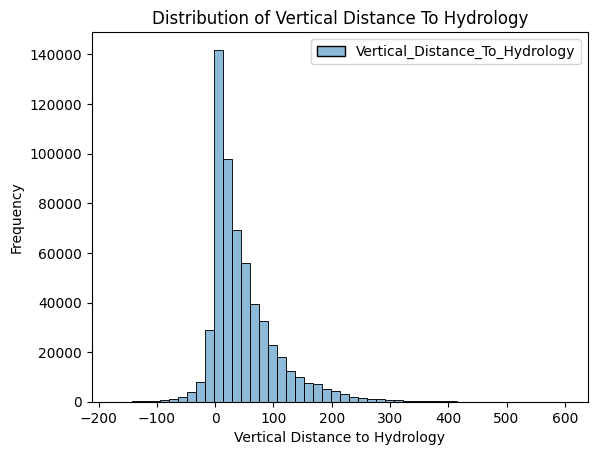

In [ ]:
sns.histplot(vertical_distance, kde=True, bins=50)
plt.title("Distribution of Vertical Distance To Hydrology")
plt.xlabel("Vertical Distance to Hydrology")
plt.ylabel("Frequency")
plt.show()

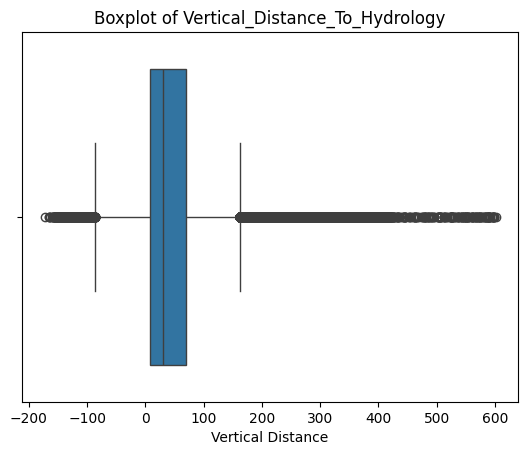

In [ ]:
sns.boxplot(x=vertical_distance["Vertical_Distance_To_Hydrology"])
plt.title("Boxplot of Vertical Distance to Hydrology")
plt.xlabel("Vertical Distance to Hydrology")
plt.show()

### Wilderness areas

From the documentation we know that each observation (entry of the db) was collected in one of the 4 wilderness areas located in the Roosevelt National Forest of Northern Colorado. The region are the following:
*   Area 1: Rawah
*   Area 2: Neota
*   Area 3: Comanche Peak
*   Area 4: Cache la Poudre




We can see how each entry of the db correspond to one of the 4 wilderness area.





In [ ]:
# check wilderness area is one hot encoding

We also know that in each Wilderness Area are present various type of Cover Type, our target class:


**Wilderness Area 1** (Rawah) - **Wilderness Area 3** (Comanche Peak)
*  Cover Type 2 - Lodgepole
*  Cover Type 1 - Spruce/Fir
*  Cover Type 5 - Aspen

**Wilderness Area 2** (Neota)

*  Cover Type 1 - Spruce/Fir

**Wilderness Area 4** (Cache la Poudre)

*  Cover Type 3 - Ponderosa pine
*  Cover Type 6 - Douglas-fir
*  Cover Type 4 - Cottonwood/willow

We want to check if this is accurate. For each `wilderness_area` we check how many `cover_type` are there.

In [48]:
wilderness_areas = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']

In [ ]:
for wild_area in wilderness_areas:
    print(f"Cover Type distrinution for {wild_area}:")
    df.groupBy("Cover_Type", wild_area).count().filter(f"{wild_area} = 1").orderBy(col("count").desc()).show()

Cover Type distrinution for Wilderness_Area1:
+----------+----------------+------+
|Cover_Type|Wilderness_Area1| count|
+----------+----------------+------+
|         2|               1|146197|
|         1|               1|105717|
|         7|               1|  5101|
|         5|               1|  3781|
+----------+----------------+------+

Cover Type distrinution for Wilderness_Area2:
+----------+----------------+-----+
|Cover_Type|Wilderness_Area2|count|
+----------+----------------+-----+
|         1|               1|18595|
|         2|               1| 8985|
|         7|               1| 2304|
+----------+----------------+-----+

Cover Type distrinution for Wilderness_Area3:
+----------+----------------+------+
|Cover_Type|Wilderness_Area3| count|
+----------+----------------+------+
|         2|               1|125093|
|         1|               1| 87528|
|         3|               1| 14300|
|         7|               1| 13105|
|         6|               1|  7626|
|         5|    

From the output we see that the documentation was partially accurate. The presence of some cover types was undestimated like the presence of Cover Type 2 (Lodgepole) in Wildernaess Area 4 or Cover Type 3 and 7 in Wildernaess Area 3

Both Wildernaess Area 1 and 3 present a predominance of Cover Type 2 (Lodgepole)
and 1 (Spruce/Fir). This might suggest that these areas may share similar environmental conditions, such as elevation or soil type.

Wilderness area 3 have a broader distributions of multiple cover types meaning that the environmental conditions may vary more. Insteas Wilderness area 2 has more specific ecological zones.


### Check for the soil

Now we check the soil type features and we see the occurrencies of them.

In [14]:
soil_type_features = [col for col in df.columns if col.startswith("Soil_Type")]

df_soil_check = df.withColumn("Soil_Type_Sum", sum(col(c) for c in soil_type_features))

invalid_soil_rows = df_soil_check.filter(col("Soil_Type_Sum") != 1)

invalid_count = invalid_soil_rows.count()

In [15]:
if invalid_count == 0:
    print("All rows have exactly one Soil_Type set to 1.")
else:
    print(f"There are {invalid_count} rows with invalid Soil_Type combinations.")
    invalid_soil_rows.show(truncate=False)

All rows have exactly one Soil_Type set to 1.


This check conferm us that the soil type is a one hot encoding. We now proceed to show the occurrence of the soil type features.

In [35]:
df_pandas = df.toPandas()

In [25]:
soil_type_counts = df_pandas.iloc[:, 14:54].sum().reset_index()
soil_type_counts.columns = ['Soil_Type', 'Count']

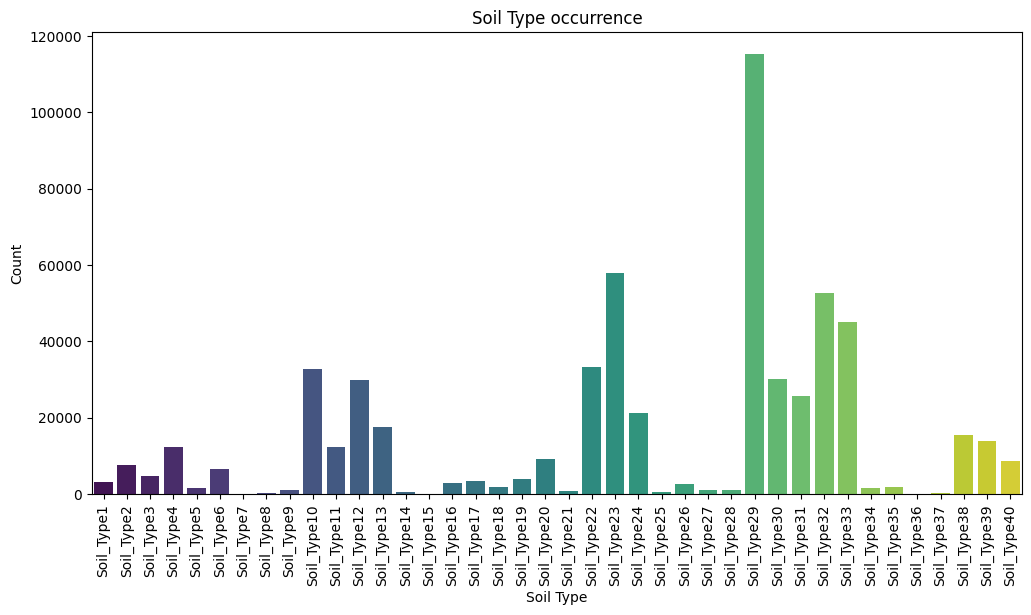

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Soil_Type', y='Count', hue='Soil_Type', data=soil_type_counts, palette='viridis')
plt.xticks(rotation=90)
plt.title('Soil Type occurrence')
plt.xlabel('Soil Type')
plt.ylabel('Count')
plt.show()

In [21]:
soil_type_features


for soil in soil_type_features:
    print(f"Cover Type distrinution for {soil}:")
    df.groupBy("Cover_Type", soil).count().filter(f"{soil} = 1").orderBy(col("count").desc()).show()

Cover Type distrinution for Soil_Type1:
+----------+----------+-----+
|Cover_Type|Soil_Type1|count|
+----------+----------+-----+
|         3|         1| 2101|
|         6|         1|  752|
|         4|         1|  178|
+----------+----------+-----+

Cover Type distrinution for Soil_Type2:
+----------+----------+-----+
|Cover_Type|Soil_Type2|count|
+----------+----------+-----+
|         3|         1| 4991|
|         6|         1| 1303|
|         2|         1|  852|
|         5|         1|  264|
|         4|         1|  115|
+----------+----------+-----+

Cover Type distrinution for Soil_Type3:
+----------+----------+-----+
|Cover_Type|Soil_Type3|count|
+----------+----------+-----+
|         3|         1| 2411|
|         2|         1| 1191|
|         4|         1| 1018|
|         6|         1|  203|
+----------+----------+-----+

Cover Type distrinution for Soil_Type4:
+----------+----------+-----+
|Cover_Type|Soil_Type4|count|
+----------+----------+-----+
|         3|         1| 750

### ALTRE PROVE????

In [55]:
df_analysis = df.withColumn(
    "Wilderness_Area",
    when(col("Wilderness_Area1") == 1, 1)
    .when(col("Wilderness_Area2") == 1, 2)
    .when(col("Wilderness_Area3") == 1, 3)
    .when(col("Wilderness_Area4") == 1, 4)
)

df_analysis = df_analysis.select("Wilderness_Area", "Cover_Type")
df_analysis = df_analysis.toPandas()

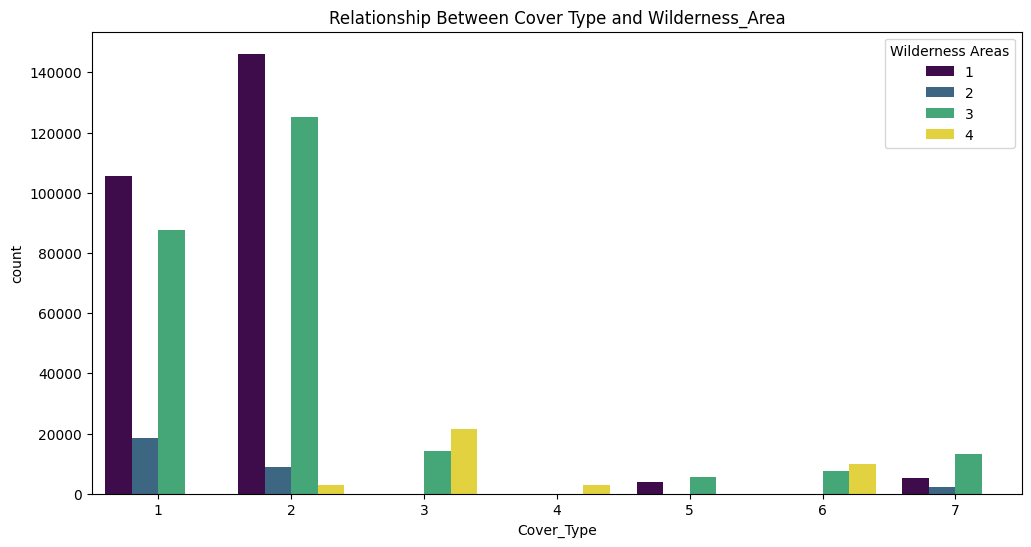

In [67]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_analysis, x="Cover_Type", hue="Wilderness_Area", palette="viridis")
plt.title(f"Relationship Between Cover Type and Wilderness_Area")
plt.xlabel("Cover Type")
plt.ylabel("count")
plt.legend(title="Wilderness Areas")
plt.show()

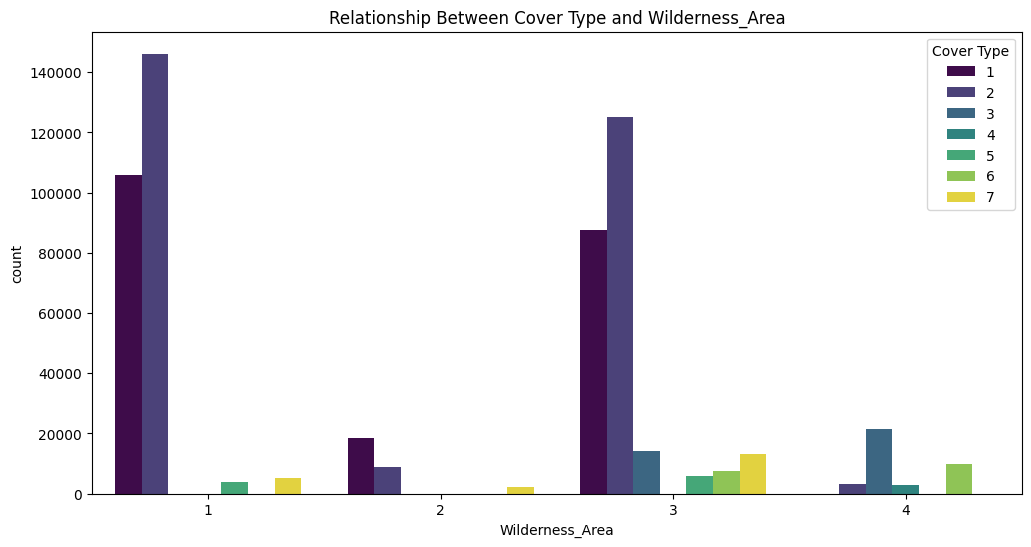

In [65]:
plt.figure(figsize=(12, 6))
#sns.histplot(x="Wilderness_Area", y="Cover_Type", data=df_analysis)
#sns.violinplot(x="Cover_Type", y="Wilderness_Area", data=df_analysis)
#sns.boxplot(x="Wilderness_Area", y="Cover_Type", data=df_analysis)
sns.countplot(data=df_analysis, x="Wilderness_Area", hue="Cover_Type", palette="viridis")
plt.title(f"Relationship Between Cover Type and Wilderness_Area")
plt.xlabel("Wilderness_Area")
plt.ylabel("count")
plt.legend(title="Cover Type")
plt.show()

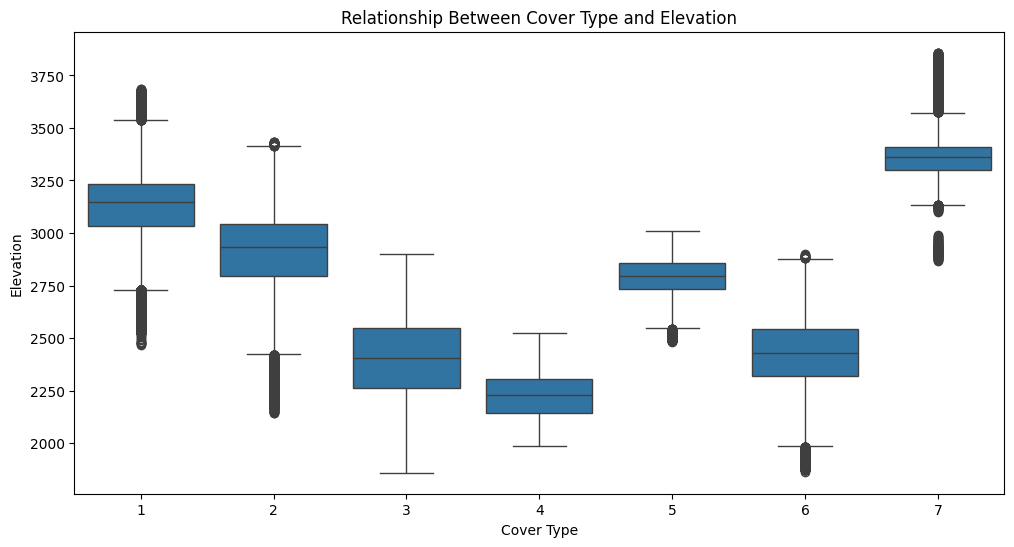

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cover_Type", y="Elevation", data=df_pandas)
plt.title("Relationship Between Cover Type and Elevation")
plt.xlabel("Cover Type")
plt.ylabel("Elevation")
plt.show()

<ipython-input-46-cd6cbf02f6df>:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(x="Cover_Type", y="Elevation", data=df_pandas, scale="width")


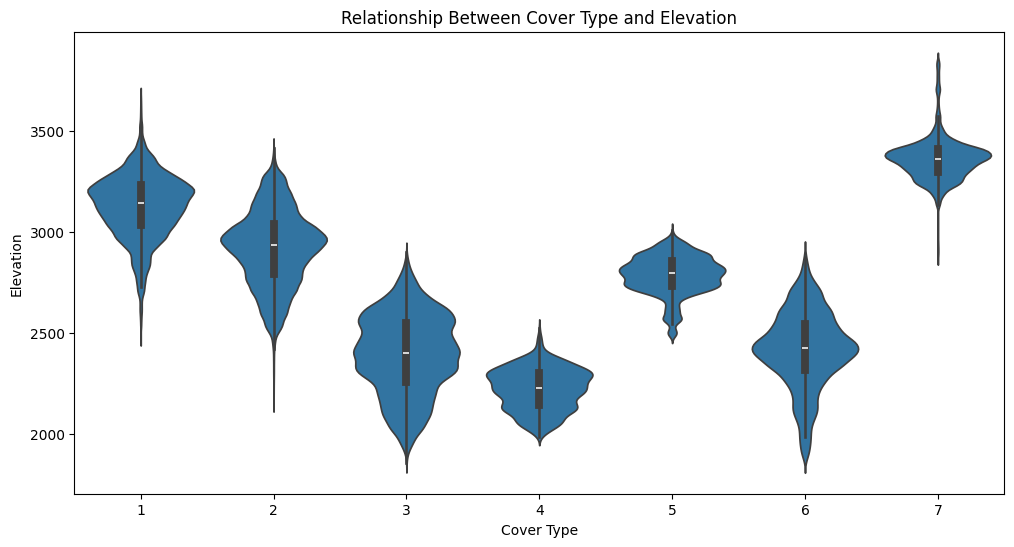

In [46]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="Cover_Type", y="Elevation", data=df_pandas, scale="width")
plt.title("Relationship Between Cover Type and Elevation")
plt.xlabel("Cover Type")
plt.ylabel("Elevation")
plt.show()

## Histograms

We proceed to trace histogramms for each feature (excluding wilderness areas and soil types) to check the distrubution of the data.

In [38]:
feature_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                      'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                      'Horizontal_Distance_To_Fire_Points']

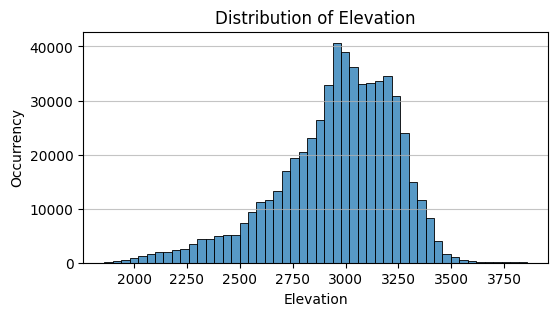

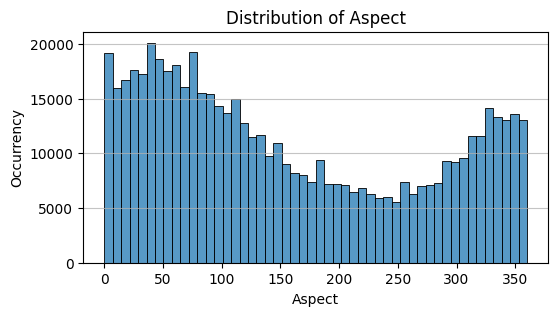

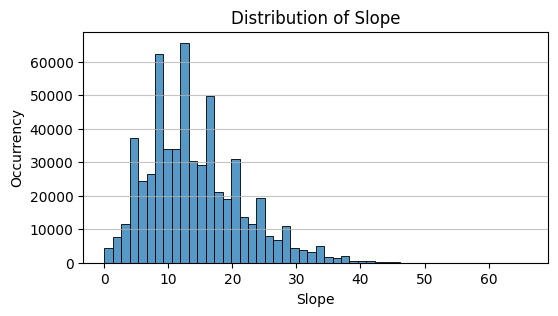

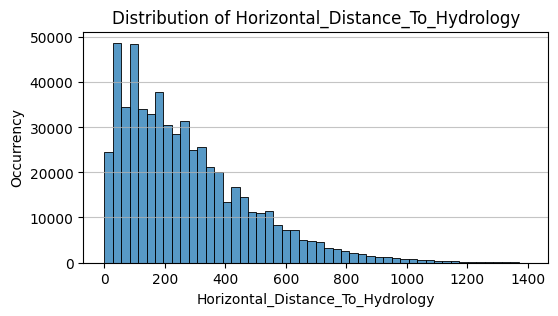

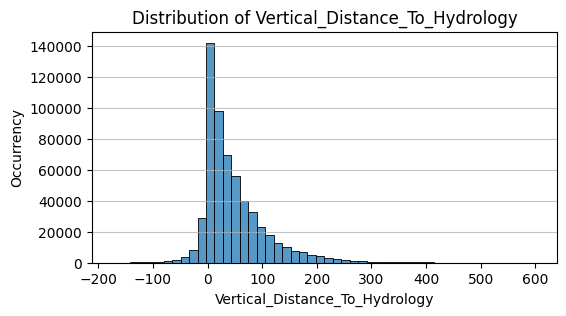

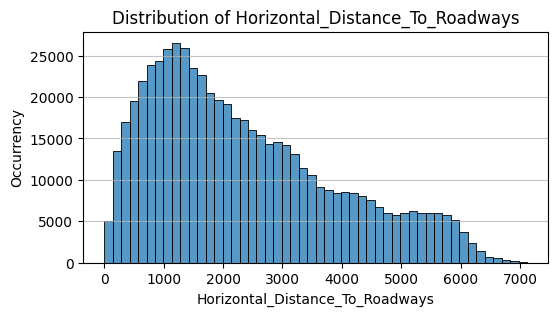

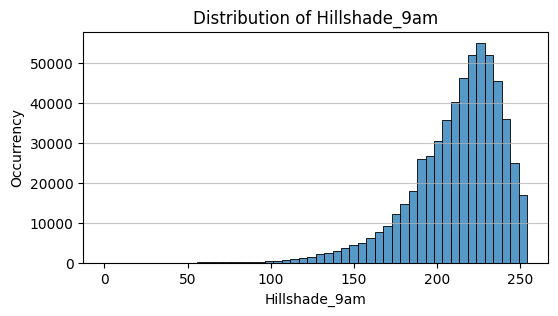

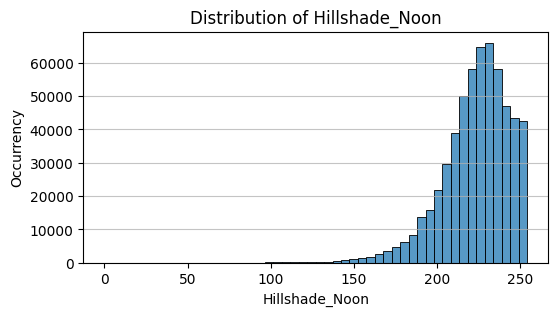

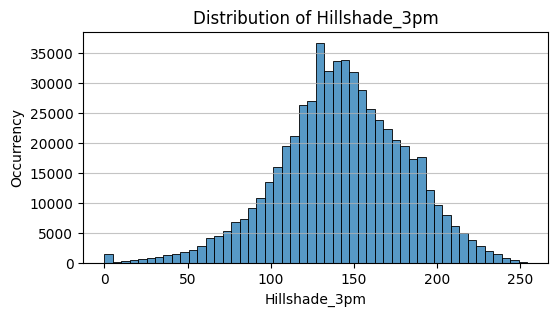

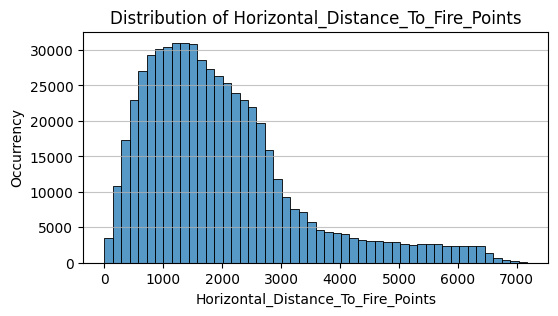

In [44]:
for feature in feature_columns:
    column_data = df.select(feature).rdd.flatMap(lambda x: x).collect()

    plt.figure(figsize=(6, 3))
    sns.histplot(column_data, bins=50)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Occurrency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

In [ ]:
sns.barplot(x='Soil_Type', y='Count', hue='Soil_Type', data=soil_type_counts, palette='viridis')

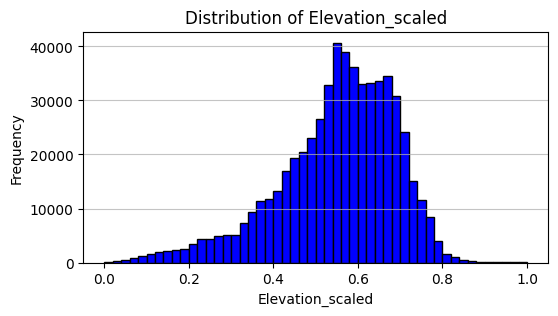

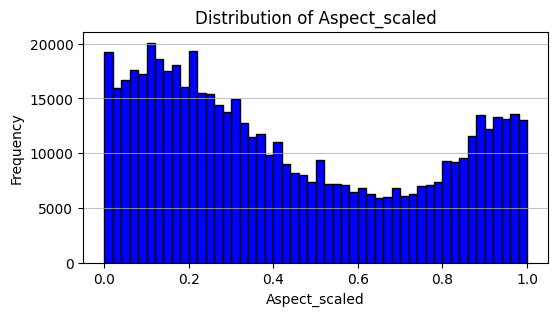

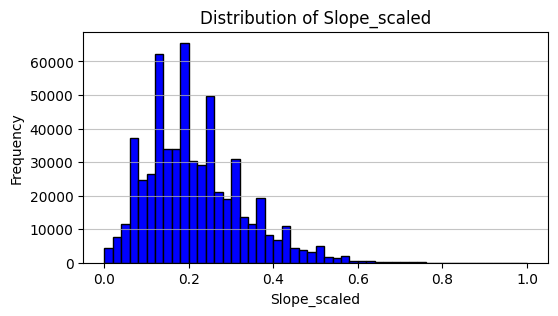

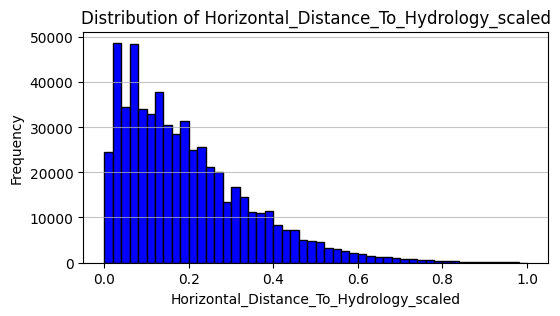

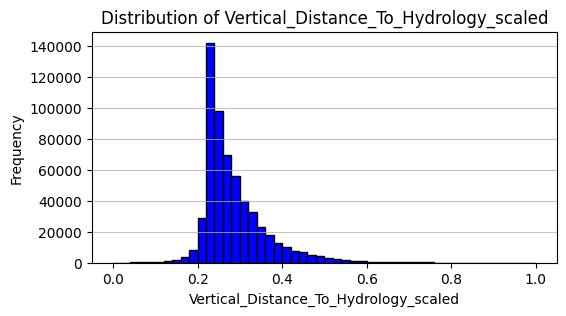

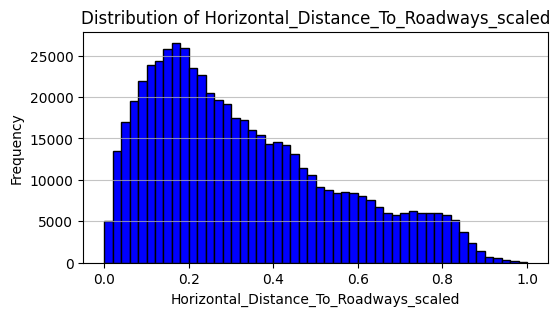

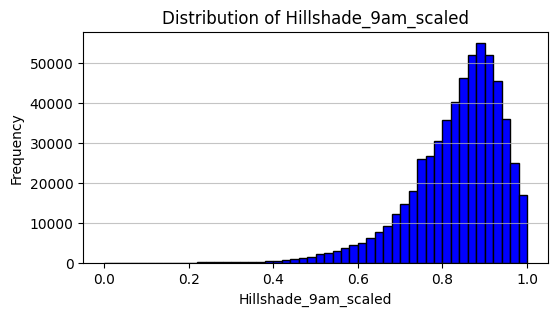

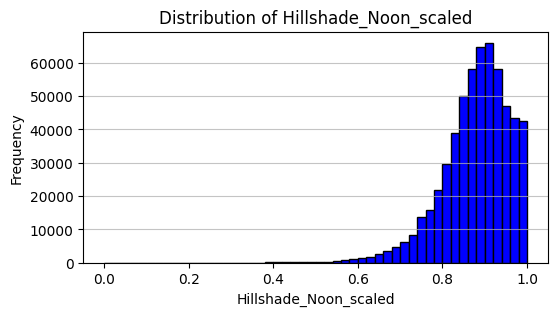

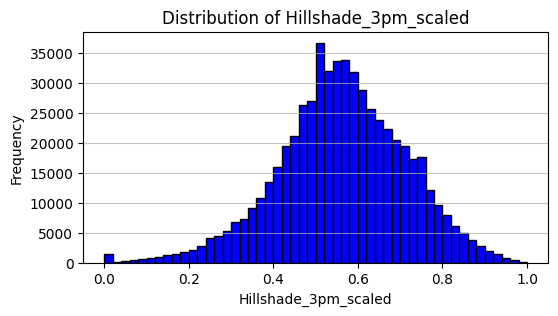

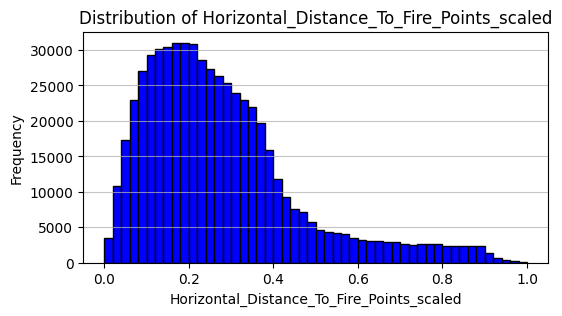

In [ ]:
# Loop through each column and collect data for histogram plotting
for col in columns_to_analyze:
    # Collect column data as a Pandas Series
    column_data = df_new.select(col).rdd.flatMap(lambda x: x).collect()

    # Plot the histogram using Matplotlib
    plt.figure(figsize=(6, 3))  # Smaller size
    plt.hist(column_data, bins=50, color='blue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Occurrency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()



Analizziamo anche le feature prima di essere scalate per vedere se tutto combacia

In [ ]:
# Select columns to analyze
columns_to_analyze_not_scaled = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
                      'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
                      'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
                      'Horizontal_Distance_To_Fire_Points']

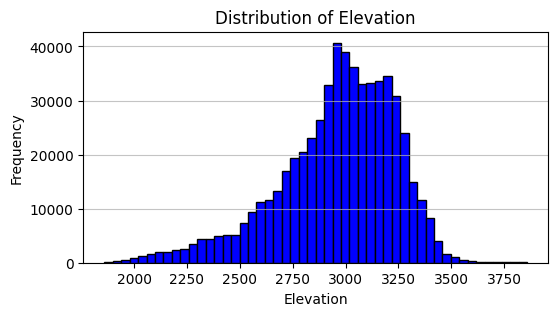

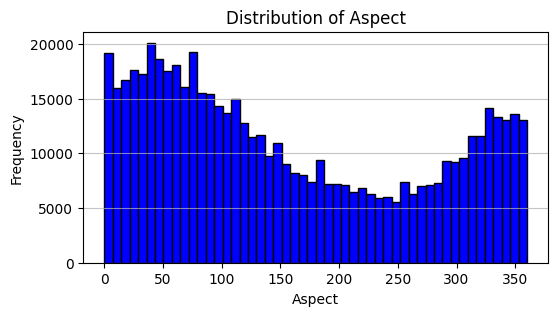

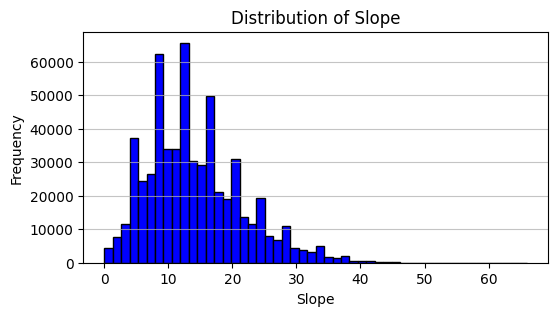

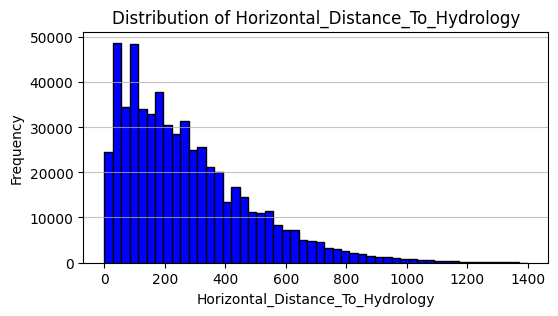

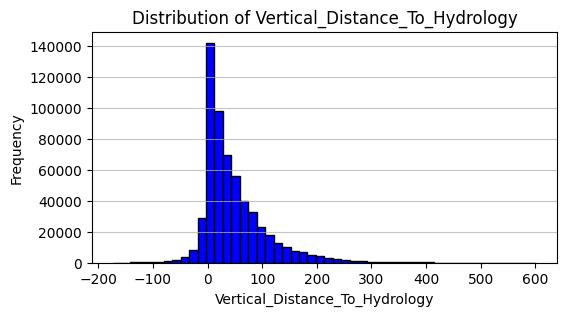

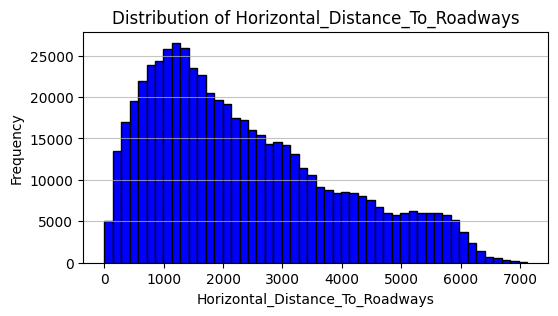

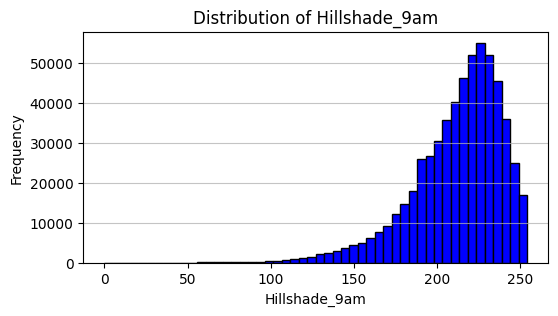

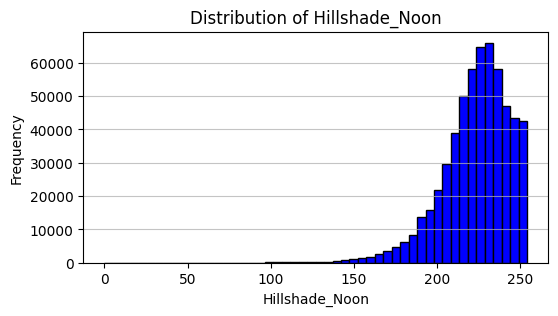

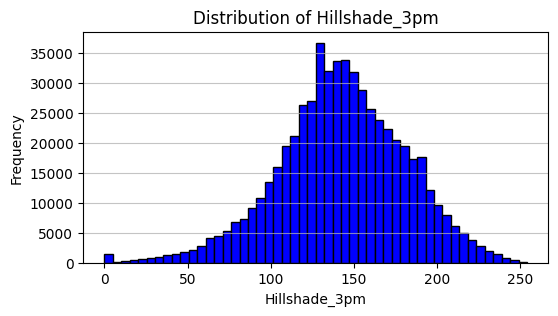

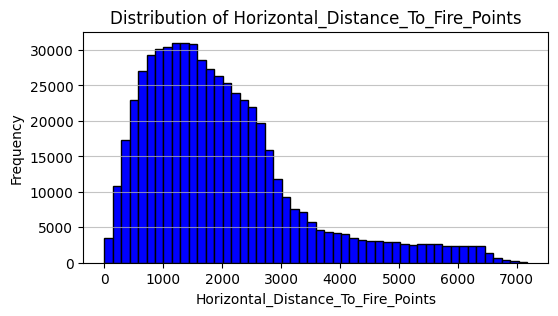

In [ ]:
# # Loop through each column and collect data for histogram plotting
# for col in columns_to_analyze_not_scaled:
#     # Collect column data as a Pandas Series
#     column_data = df.select(col).rdd.flatMap(lambda x: x).collect()

#     # Plot the histogram using Matplotlib
#     plt.figure(figsize=(6, 3))  # Smaller size
ax, fig = plt.figure((1, 2), figsize=(6,3))
ax[0].hist(column_data)
ax[1]

#     plt.hist(column_data, bins=50, color='blue', edgecolor='black')
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Occurrency')
#     plt.grid(axis='y', alpha=0.75)
#     plt.show()


Bisogna controllare quei parametri belli tipo Recall etc... tipo

## Pre processing

As seen in the Dataset Exploration section the dataset values have different scales and units of measurement. Many ML algorithms are sensitive to magnitude changes, so we want to scale the features in order to be able to increase the performance at training time and the convergence of the model.

In [ ]:
input_columns = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
                 "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
                 "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm", "Horizontal_Distance_To_Fire_Points"]

In [ ]:
assembler = VectorAssembler(inputCols=input_columns, outputCol="features")
df_assembled = assembler.transform(df)

In [ ]:
df_assembled.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area

We change the classification class in such way that the classes start from 0.

In [ ]:
df_assembled = df_assembled.withColumn("Cover_Type", df["Cover_Type"] - 1)
df_assembled.groupBy("Cover_Type").count().orderBy("Cover_Type").show()

+----------+------+
|Cover_Type| count|
+----------+------+
|         0|211840|
|         1|283301|
|         2| 35754|
|         3|  2747|
|         4|  9493|
|         5| 17367|
|         6| 20510|
+----------+------+



### Min Max Scaler

In [ ]:
minmax_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
minmax_model = minmax_scaler.fit(df_assembled)

In [ ]:
df_mm_scaled = minmax_model.transform(df_assembled)
df_mm_scaled.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_

We can see that the values range from 0 to 1.

In [ ]:
df_mm_scaled.select("scaled_features").show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                       |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.36868434217108553,0.14166666666666666,0.045454545454545456,0.18468146027201143,0.2235142118863049,0.07165940705353378,0.8700787401574803,0.9133858267716535,0.5826771653543307,0.875365955667085]  |
|[0.36568284142071034,0.15555555555555556,0.030303030303030304,0.15175375805297064,0.2157622739018088,0.054798370099761136,0.8661417322834646,0.9251968503937008,0.5944881889763779,0.86783772480133

Now we assemble the scaled features with the 40 one hot encoded Soil Type features with Vector Assembler

In [ ]:
soil_type_cols = [col for col in df.columns if col.startswith("Soil_Type")]

final_assembler = VectorAssembler(
    inputCols=["scaled_features"] + soil_type_cols,  #add soil_type col to the scaled_features
    outputCol="final_features"
)

df_mm_final = final_assembler.transform(df_mm_scaled)

In [ ]:
df_mm_final.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fi

In [ ]:
df_mm_final.select("final_features").show(5, truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(50,[0,1,2,3,4,5,6,7,8,9,38],[0.36868434217108553,0.14166666666666666,0.045454545454545456,0.18468146027201143,0.2235142118863049,0.07165940705353378,0.8700787401574803,0.9133858267716535,0.5826771653543307,0.875365955667085,1.0])  |
|(50,[0,1,2,3,4,5,6,7,8,9,38],[0.36568284142071034,0.1555555

### Standard Scaler

In [ ]:
standardScaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
std_model = standardScaler.fit(df_assembled)

In [ ]:
df_std_scaled = std_model.transform(df_assembled)
df_std_scaled.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_

In [ ]:
df_std_scaled.select("scaled_features").show(5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                                         |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-1.2978039731955449,-0.9351561765108982,-1.4828185057396976,-0.053767354866423554,-0.796271909057315,-1.1801448544140933,0.3307429270918281,0.43914293510260455,0.14296027552922155,3.2462802628404894]|
|[-1.3192337129849612,-0.8904789023109558,-1.6163612017122402,-0.2701876769662561,-0.8991962792425542,-1.2571046910108385,0.2933875235160505,0.5908980040725195,0.22134138328529157,3.205500

In [ ]:
soil_type_cols = [col for col in df.columns if col.startswith("Soil_Type")]

In [ ]:
final_assembler = VectorAssembler(
    inputCols=["scaled_features"] + soil_type_cols,  #add soil_type col to the scaled_features
    outputCol="final_features"
)

df_std_final = final_assembler.transform(df_std_scaled)

In [ ]:
df_std_final.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fi

In [ ]:
df_std_final.select('final_features').show(5, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|final_features                                                                                                                                                                                                                            |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(50,[0,1,2,3,4,5,6,7,8,9,38],[-1.2978039731955449,-0.9351561765108982,-1.4828185057396976,-0.053767354866423554,-0.796271909057315,-1.1801448544140933,0.3307429270918281,0.43914293510260455,0.14296027552922155,3.2462802628404894,1.0])|
|(50,[0,1,2,3,4,5,6,7,8,9,38],[-1.3192337129849612,-

## Evaluation

MulticlassCLassificationEvaluator
- Accuracy
- F1 Score
- Precision and Recall

Things you can put in `evaluator.setMetricName("accuracy")`

`(f1|accuracy|weightedPrecision|weightedRecall|weightedTruePositiveRate| weightedFalsePositiveRate|weightedFMeasure|truePositiveRateByLabel| falsePositiveRateByLabel|precisionByLabel|recallByLabel|fMeasureByLabel| logLoss|hammingLoss)`

In [ ]:
# define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Cover_Type", predictionCol="prediction")

In [ ]:
def compute_metrics(predictions):
    evaluator.setMetricName("accuracy")
    accuracy = evaluator.evaluate(predictions)
    print(f"Test Accuracy = {accuracy:.2f}")

    evaluator.setMetricName("f1")
    f1_score = evaluator.evaluate(predictions)
    print(f"F1 Score = {f1_score:.2f}")

    evaluator.setMetricName("weightedPrecision")
    weighted_precision = evaluator.evaluate(predictions)
    print(f"Weighted Precision = {weighted_precision:.2f}")

    evaluator.setMetricName("weightedRecall")
    weighted_recall = evaluator.evaluate(predictions)
    print(f"Weighted Recall = {weighted_recall:.2f}")


Random Forest evaluation

In [ ]:
compute_metrics(rfPred)

Test Accuracy = 0.71
F1 Score = 0.68
Weighted Precision = 0.68
Weighted Recall = 0.71


## Train and Test Set

We see how Spark uses a Sparse Representation to save mamory since we have a lot of binary features.

**Why Use Sparse Representation?**
Sparse representation is useful because many machine learning datasets have a significant number of binary features or other features that are often zero. Instead of storing all the zeros, the sparse vector format only stores the positions and values of the non-zero elements, saving memory. - from internet

Split the DataFrame in train set and test set

In [ ]:
(trainSplit_mm, testSplit_mm) = df_mm_final.randomSplit([0.7, 0.3], seed=42)

In [ ]:
(trainSplit_std, testSplit_std) = df_std_final.randomSplit([0.7, 0.3], seed=42)

In [ ]:
num_rows = trainSplit_mm.count()
num_columns = len(trainSplit_mm.columns)
print(f"The train split has {num_rows} rows and {num_columns} columns.")

num_rows = testSplit_mm.count()
num_columns = len(testSplit_mm.columns)
print(f"The test split has {num_rows} rows and {num_columns} columns.")

The train split has 406644 rows and 58 columns.
The test split has 174368 rows and 58 columns.


In [ ]:
print("Training Dataset Count: " + str(trainSplit_mm.count()))
print("Test Dataset Count: " + str(testSplit_mm.count()))

Training Dataset Count: 406644
Test Dataset Count: 174368


In [ ]:
# trainSplit.show(5)
# testSplit.show(5)

## Algorithms

In this project we can see the application of 3 Machine Learning **classification** algorithms. In particular:

*   Naive Bayes
*   Random Forest
*   Logistic Regression

### Naive Bayes

In [ ]:
nb = NaiveBayes(labelCol="Cover_Type", \
                featuresCol="final_features", \
                modelType="multinomial", \
                smoothing=1.0)

In [ ]:
# fit and evaluate the model
nbModel = nb.fit(trainSplit_mm)
nbPred = nbModel.transform(testSplit_mm)

In [ ]:
compute_metrics(nbPred) # smoothing=1

Test Accuracy = 0.21
F1 Score = 0.18
Weighted Precision = 0.21
Weighted Recall = 0.21


The Naive Bayes method does not return great results, being just a bit better than a random classifier. This could be due to the fact that the dataset is highly imbalanced as seen in the Dataset Exploration section. By showing the predictions of the model we see that the fist 2 classes, the most numerous, are also those that contain the most predictions.

In [ ]:
nbPred.groupBy("prediction").count().orderBy(col("count").desc()).show()

+----------+------+
|prediction| count|
+----------+------+
|       1.0|108125|
|       0.0| 47143|
|       2.0| 18429|
|       6.0|   362|
|       5.0|   306|
|       3.0|     3|
+----------+------+



A further analysis might be conducted by balancing the dataset, either undersampling the most numerous classes, either assigning weights to the classes (in particular high weights to the minority classes in order to counteract the imbalance).

In [ ]:
total_samples = trainSplit_mm.count()
total_samples

406644

#### Weigthing col

In [ ]:
# check il calcolo per creare il weight
class_counts_df = trainSplit_mm.groupBy("Cover_Type").count()

class_counts = class_counts_df.collect()

class_weights = {row['Cover_Type']: total_samples / row['count'] for row in class_counts}

In [ ]:
trainSplit_weights = trainSplit_mm.withColumn("weight",
                                    when(trainSplit_mm.Cover_Type == 1, class_weights[1])
                                   .when(trainSplit_mm.Cover_Type == 2, class_weights[2])
                                   .when(trainSplit_mm.Cover_Type == 3, class_weights[3])
                                   .when(trainSplit_mm.Cover_Type == 4, class_weights[4])
                                   .when(trainSplit_mm.Cover_Type == 5, class_weights[5])
                                   .when(trainSplit_mm.Cover_Type == 6, class_weights[6])
                                   .when(trainSplit_mm.Cover_Type == 7, class_weights[7])
                                )

In [ ]:
nb_weight = NaiveBayes(labelCol="Cover_Type", \
                featuresCol="final_features", \
                modelType="multinomial", \
                smoothing=1.0, \
                weightCol="weight")

In [ ]:
nbModel_weight = nb_weight.fit(trainSplit_weights)
nbPred_weight = nbModel_weight.transform(testSplit_mm)

In [ ]:
compute_metrics(nbPred_weight)

Test Accuracy = 0.16
F1 Score = 0.16
Weighted Precision = 0.25
Weighted Recall = 0.16


### Random Forest

In [ ]:
# define rf model
rf_2 = RandomForestClassifier(labelCol="Cover_Type", \
                            featuresCol="final_features", \
                            numTrees=150, \
                            maxDepth=8, \
                            maxBins=40, \
                            seed=42)

In [ ]:
rfModel_2 = rf_2.fit(trainSplit_mm)
rfPred_2 = rfModel_2.transform(testSplit_mm)

In [ ]:
compute_metrics(rfPred_2)

Test Accuracy = 0.70
F1 Score = 0.67
Weighted Precision = 0.69
Weighted Recall = 0.70


In [ ]:
# define rf model
rf_3 = RandomForestClassifier(labelCol="Cover_Type", \
                            featuresCol="scaled_features", \
                            numTrees=150, \
                            maxDepth=8, \
                            maxBins=40, \
                            seed=42)

In [ ]:
rfModel_3 = rf_3.fit(trainSplit_std)

In [ ]:
rfPred_3 = rfModel_3.transform(testSplit_std)

In [ ]:
compute_metrics(rfPred_3)

Test Accuracy = 0.70
F1 Score = 0.67
Weighted Precision = 0.69
Weighted Recall = 0.70


In [ ]:
rf_spark = RandomForestClassifier(labelCol="Cover_Type", \
                                  featuresCol="final_features", \
                                  numTrees=100,
                                  maxDepth=30,
                                  minInstancesPerNode=2,
                                  featureSubsetStrategy="sqrt",
                                  seed=42)

In [ ]:
# fit and evaluate the model
rfModel = rf_spark.fit(trainSplit_mm)
rfPred = rfModel.transform(testSplit_mm)

In [ ]:
compute_metrics(rfPred)

Test Accuracy = 0.89
F1 Score = 0.88
Weighted Precision = 0.89
Weighted Recall = 0.89


In [ ]:
rfPred.select("Cover_Type", "prediction", "features").show()

In [ ]:
rfModel.featureImportances

### Logistic regression

Better performance having:
-  a lower `regParam`
- `standardization` set to True


In [ ]:
lr = LogisticRegression(featuresCol="final_features",
                        labelCol="Cover_Type",
                        maxIter=500,
                        regParam=0.00,
                        elasticNetParam=0.8,
                        tol=1e-10,
                        standardization=True)

In [ ]:
lrModel = lr.fit(trainSplit_mm)
lrPred = lrModel.transform(testSplit_mm)

In [ ]:
compute_metrics(lrPred)

Test Accuracy = 0.72
F1 Score = 0.70
Weighted Precision = 0.70
Weighted Recall = 0.72


In [ ]:
compute_metrics(lrPred)# lr = LogisticRegression(featuresCol="final_features",
                                                    # labelCol="Cover_Type",
                                                    # maxIter=500,
                                                    # regParam=0.00,
                                                    # elasticNetParam=1.0, <======== cambiato questo
                                                    # standardization=True)

Test Accuracy = 0.72
F1 Score = 0.70
Weighted Precision = 0.70
Weighted Recall = 0.72


In [ ]:
compute_metrics(lrPred)     # lr = LogisticRegression(featuresCol="final_features",
                                                            # labelCol="Cover_Type",
                                                            # maxIter=500,
                                                            # regParam=0.00, <======== cambiato questo
                                                            # elasticNetParam=0.0,
                                                            # standardization=True)

Test Accuracy = 0.72
F1 Score = 0.70
Weighted Precision = 0.70
Weighted Recall = 0.72


In [ ]:
compute_metrics(lrPred) # lr = LogisticRegression(featuresCol="final_features",
                                                # labelCol="Cover_Type",
                                                # maxIter=500,
                                                # regParam=0.01,  <======== cambiato questo
                                                # elasticNetParam=0.0,
                                                # standardization=True)

Test Accuracy = 0.70
F1 Score = 0.68
Weighted Precision = 0.68
Weighted Recall = 0.70


In [ ]:
# QUESTO ANCHE DA ELIMINARE, BASTA CHE TI RICORDI CHE TI è SERVITO PER AVERE regParam=0.8 CHE NON FUNZIA (tropo alto)

compute_metrics(lrPred)     # lr = LogisticRegression(featuresCol="final_features",
                                # labelCol="Cover_Type",
                                # maxIter=500,
                                # regParam=0.8, <======== cambiato questo
                                # elasticNetParam=0.0,
                                # standardization=True)

Test Accuracy = 0.60
F1 Score = 0.54
Weighted Precision = 0.59
Weighted Recall = 0.60


In [ ]:
compute_metrics(lrPred)     #lr = LogisticRegression(featuresCol="final_features",
                                    # labelCol="Cover_Type",
                                    # maxIter=500,
                                    # regParam=0.1,
                                    # elasticNetParam=0.0,
                                    # standardization=True) <======== cambiato questo

Test Accuracy = 0.68
F1 Score = 0.64
Weighted Precision = 0.67
Weighted Recall = 0.68


In [ ]:
compute_metrics(lrPred) # lr = LogisticRegression(featuresCol="final_features",
                                                    # labelCol="Cover_Type",
                                                    # maxIter=500,
                                                    # regParam=0.1,
                                                    # elasticNetParam=0.0,
                                                    # standardization=False)

Test Accuracy = 0.55
F1 Score = 0.45
Weighted Precision = 0.54
Weighted Recall = 0.55


#### DA ELIMINARE - CROSS VALIDATION PER TROVARE I PARAM MIGLIORI

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
train_lr = trainSplit_lr.withColumnRenamed("Cover_Type", "label")
trest_lr = testSplit_lr.withColumnRenamed("Cover_Type", "label")

list_to_drop = ["features", "scaled_features"]

train_lr = train_lr.drop(*list_to_drop)
trest_lr = trest_lr.drop(*list_to_drop)

# train_lr = train_lr.drop(train_lr.scaled_features)
# trest_lr = trest_lr.drop(trest_lr.scaled_features)

train_lr = train_lr.withColumnRenamed("final_features", "features")
trest_lr = trest_lr.withColumnRenamed("final_features", "features")

In [ ]:
train_lr.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area2|Wil

In [ ]:
lr_cross = LogisticRegression(featuresCol="features",
                        labelCol="label",
                        maxIter=500,
                        regParam=0.00,
                        elasticNetParam=0.8,
                        tol=1e-10,
                        standardization=True)

## Further Experimentation

### Feature extraction using PCA

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
pca = PCA(k=2, inputCol="final_features", outputCol="pca_features")

In [ ]:
pcaModel = pca.fit(df_mm_final)

In [ ]:
result = pcaModel.transform(df_mm_final)
result.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+--------------------+--------------------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Hori

#### Logistic Regression after PCA

In [ ]:
(trainSplit_pca, testSplit_pca) = result.randomSplit([0.7, 0.3], seed=42)

In [ ]:
lr = LogisticRegression(featuresCol="pca_features",
                        labelCol="Cover_Type",
                        maxIter=500,
                        regParam=0.00,
                        elasticNetParam=0.8,
                        tol=1e-10,
                        standardization=False)

In [ ]:
lrModel = lr.fit(trainSplit_pca)
lrPred = lrModel.transform(testSplit_pca)

In [ ]:
compute_metrics(lrPred)

Test Accuracy = 0.49
F1 Score = 0.32
Weighted Precision = 0.24
Weighted Recall = 0.49


In [ ]:
compute_metrics(lrPred)

Test Accuracy = 0.49
F1 Score = 0.32
Weighted Precision = 0.24
Weighted Recall = 0.49



### Feature selection UnivariateFeatureSelector

### Clustering

In [ ]:
from pyspark.ml.clustering import KMeans

In [ ]:
kmeans = KMeans(featuresCol="final_features", k=7, seed=42)  # Start with k=7
kmeans_model = kmeans.fit(df_mm_final)
clustered_df = kmeans_model.transform(df_mm_final)

In [ ]:
clustered_df.groupBy("prediction").count().orderBy(col("prediction")).show()
clustered_df.groupBy("Cover_Type").count().orderBy(col("Cover_Type")).show()

+----------+------+
|prediction| count|
+----------+------+
|         0| 97673|
|         1| 87922|
|         2| 29971|
|         3| 85432|
|         4|115247|
|         5|117823|
|         6| 46944|
+----------+------+

+----------+------+
|Cover_Type| count|
+----------+------+
|         1|211840|
|         2|283301|
|         3| 35754|
|         4|  2747|
|         5|  9493|
|         6| 17367|
|         7| 20510|
+----------+------+



In [ ]:
cluster_class_mapping = clustered_df.groupBy("prediction", "Cover_Type").count()

In [ ]:
cluster_class_mapping.orderBy("prediction", "Cover_Type").show()

+----------+----------+-----+
|prediction|Cover_Type|count|
+----------+----------+-----+
|         0|         1|39506|
|         0|         2|54864|
|         0|         3|  111|
|         0|         5|  978|
|         0|         6|  739|
|         0|         7| 1475|
|         1|         1|43201|
|         1|         2|40979|
|         1|         5| 2810|
|         1|         6|   29|
|         1|         7|  903|
|         2|         1| 2693|
|         2|         2|27278|
|         3|         1|53289|
|         3|         2|15431|
|         3|         5|   16|
|         3|         7|16696|
|         4|         1|41911|
|         4|         2|71399|
|         4|         5| 1132|
+----------+----------+-----+
only showing top 20 rows



In [ ]:
pivot_table = cluster_class_mapping.groupBy("prediction") \
                                   .pivot("Cover_Type") \
                                   .sum("count")

pivot_table = pivot_table.fillna(0)

pivot_table.show()

+----------+-----+-----+-----+----+----+-----+-----+
|prediction|    1|    2|    3|   4|   5|    6|    7|
+----------+-----+-----+-----+----+----+-----+-----+
|         1|43201|40979|    0|   0|2810|   29|  903|
|         6|23027|22911|    0|   0| 379|  201|  426|
|         3|53289|15431|    0|   0|  16|    0|16696|
|         5| 8213|50439|35643|2747|4178|16398|  205|
|         4|41911|71399|    0|   0|1132|    0|  805|
|         2| 2693|27278|    0|   0|   0|    0|    0|
|         0|39506|54864|  111|   0| 978|  739| 1475|
+----------+-----+-----+-----+----+----+-----+-----+



## ML Algorithms OLD!!!

### A2. df_scaled

In [ ]:
(trainSplit, testSplit) = df_mm_scaled.randomSplit([0.7, 0.3], seed=42)

In [ ]:
# define rf model
rf = RandomForestClassifier(labelCol="Cover_Type", \
                            featuresCol="scaled_features", \
                            numTrees=150, \
                            maxDepth=8, \
                            maxBins=40, \
                            seed=42)

In [ ]:
# fit and evaluate the model
rfModel = rf.fit(trainSplit)
rfPred = rfModel.transform(testSplit)

In [ ]:
compute_metrics(rfPred)

Test Accuracy = 0.73
F1 Score = 0.71
Weighted Precision = 0.74
Weighted Recall = 0.73


### B. Naive Bayes

In [ ]:
nb = NaiveBayes(labelCol="Cover_Type", \
                featuresCol="scaled_features", \
                modelType="multinomial", \
                smoothing=0.5)
                # smoothing=1.0, \
                # modelType="multinomial", \
                # weightCol="weight")

In [ ]:
# fit and evaluate the model
nbModel = nb.fit(trainSplit)
nbPred = nbModel.transform(testSplit)

In [ ]:
# metric with modelType="multinomial" - smoothing=0.5
compute_metrics(nbPred)

Test Accuracy = 0.36
F1 Score = 0.19
Weighted Precision = 0.13
Weighted Recall = 0.36


In [ ]:
# metric with modelType="multinomial" + smoothing=0.3
compute_metrics(nbPred)

Test Accuracy = 0.36
F1 Score = 0.19
Weighted Precision = 0.13
Weighted Recall = 0.36


In [ ]:
# metric with modelType="multinomial" + smoothing=0.8
compute_metrics(nbPred)

Test Accuracy = 0.36
F1 Score = 0.19
Weighted Precision = 0.13
Weighted Recall = 0.36


In [ ]:
nbPred.select("Cover_Type", "prediction", "features").show(5)

+----------+----------+--------------------+
|Cover_Type|prediction|            features|
+----------+----------+--------------------+
|         3|       2.0|(54,[0,1,2,3,4,5,...|
|         3|       2.0|(54,[0,1,2,3,4,5,...|
|         6|       2.0|(54,[0,1,2,3,4,5,...|
|         6|       2.0|(54,[0,1,2,3,4,5,...|
|         6|       2.0|(54,[0,1,2,3,4,5,...|
+----------+----------+--------------------+
only showing top 5 rows



## Prove con db non normalizzato

In [ ]:
feature_columns_N = ['Elevation',
                     'Aspect',
                     'Slope',
                     'Horizontal_Distance_To_Hydrology',
                     'Vertical_Distance_To_Hydrology',
                     'Horizontal_Distance_To_Roadways',
                     'Hillshade_9am',
                     'Hillshade_Noon',
                     'Hillshade_3pm',
                     'Horizontal_Distance_To_Fire_Points',
                     'Wilderness_Area1',
                     'Wilderness_Area2',
                     'Wilderness_Area3',
                     'Wilderness_Area4',
                     'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
                     'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
                     'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15',
                     'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
                     'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25',
                     'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
                     'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
                     'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
                     ]

In [ ]:
# Use VectorAssembler to combine feature columns into a single "features" column
assembler_N = VectorAssembler(inputCols=feature_columns_N, outputCol="features")

df_assembled_N = assembler_N.transform(df)


In [ ]:
df_assembled_N.show(5)

+---------+------+-----+--------------------------------+------------------------------+-------------------------------+-------------+--------------+-------------+----------------------------------+----------------+----------------+----------------+----------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+--------------------+
|Elevation|Aspect|Slope|Horizontal_Distance_To_Hydrology|Vertical_Distance_To_Hydrology|Horizontal_Distance_To_Roadways|Hillshade_9am|Hillshade_Noon|Hillshade_3pm|Horizontal_Distance_To_Fire_Points|Wilderness_Area1|Wilderness_Area

In [ ]:
(trainSplit_N, testSplit_N) = df_assembled_N.randomSplit([0.7, 0.3], seed=42)

Random forest

In [ ]:
# define rf model
rf_N = RandomForestClassifier(labelCol="Cover_Type", \
                            featuresCol="features", \
                            numTrees=150, \
                            maxDepth=8, \
                            maxBins=40, \
                            seed=42)

In [ ]:
rf_N = RandomForestClassifier(labelCol="Cover_Type", \
                                  featuresCol="features", \
                                  numTrees=100,
                                  maxDepth=30,
                                  minInstancesPerNode=2,
                                  featureSubsetStrategy="sqrt",
                                  seed=42)

In [ ]:
# fit and evaluate the model
rfModel_N = rf_N.fit(trainSplit_N)
rfPred_N = rfModel_N.transform(testSplit_N)

In [ ]:
compute_metrics(rfPred_N)

Test Accuracy = 0.88
F1 Score = 0.88
Weighted Precision = 0.88
Weighted Recall = 0.88
